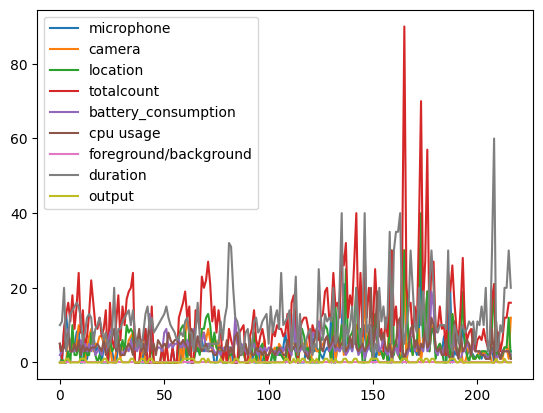

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd



# Read the file with detected encoding
df = pd.read_csv('vaemodelnewdataset.txt',sep='\t')

df.plot()
plt.show()




In [168]:
import tensorflow as tf
print(tf.__version__)

2.13.1


In [169]:
print(df.shape)
df['installation_source'].replace(['playstore', 'other'],
                        [0, 1], inplace=True)

(217, 11)


C:\Users\yerrabelli.a\AppData\Local\Temp\ipykernel_10472\2191456162.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['installation_source'].replace(['playstore', 'other'],
C:\Users\yerrabelli.a\AppData\Local\Temp\ipykernel_10472\2191456162.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df

In [170]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

train_data, test_data = train_test_split(df, test_size=0.1, random_state=1,shuffle=True)
X_train = train_data.drop(['output', 'appname'], axis=1).values
y_train = train_data['output'].values
X_test = test_data.drop(['output', 'appname'], axis=1).values
y_test = test_data['output'].values



In [171]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
tf.config.run_functions_eagerly(True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# # Convert scaled data to TensorFlow tensor
X_train_tf = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)

# Define the VAE architecture
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
        
        # Encoder
        self.encoder = keras.Sequential([
            layers.Input(shape=(9,)),
            layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
            layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
            layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
            layers.Dense(8, activation='relu', kernel_initializer='he_normal'),
            
            
            layers.Dense(latent_dim + latent_dim),  # Mean and log variance
        ])
        
        # Decoder
        self.decoder = keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(32, activation='relu', kernel_initializer='he_uniform'),
            layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
            layers.Dense(16, activation='relu', kernel_initializer='he_uniform'),
  
            layers.Dense(9),  # Output shape is same as input
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z):
        logits = self.decoder(z)
        return logits

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)

# Custom loss function for VAE
    def compute_loss(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)
    
        # Reconstruction loss
        mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
        reconstruction_loss = tf.reduce_sum(mse(x, x_logit), axis=-1)
    
        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=-1)
        kl_loss = tf.maximum(kl_loss, 0.0) 
        
        # Total loss
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        
        return total_loss

# Training step function

    @tf.function(input_signature=[
        tf.TensorSpec([16, 9], tf.float32),
    ])
    def train(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {
            "loss": loss
        }

# Training loop
def train_vae(model, dataset, optimizer, epochs):
    for epoch in range(epochs):
        epoch_loss = 0
        for train_x in dataset:
            loss = model.train(train_x)
            epoch_loss += loss["loss"]
        avg_epoch_loss = epoch_loss / 32
        print(f'Epoch: {epoch + 1}, Loss: {avg_epoch_loss:.4f}')

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
print(X_train.shape)

(195, 9)


In [173]:
latent_dim = 2
vae = VAE(latent_dim)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)

# Create a TensorFlow dataset from the training data
train_dataset = tf.data.Dataset.from_tensor_slices(X_train_scaled).shuffle(buffer_size=50).batch(32)

# Train the VAE
train_vae(vae,train_dataset, optimizer,1000)

Epoch: 1, Loss: 9.9222
Epoch: 2, Loss: 7.9216
Epoch: 3, Loss: 7.5249
Epoch: 4, Loss: 7.2555
Epoch: 5, Loss: 6.6570
Epoch: 6, Loss: 6.0445
Epoch: 7, Loss: 6.0511
Epoch: 8, Loss: 5.9733
Epoch: 9, Loss: 5.9678
Epoch: 10, Loss: 5.9733
Epoch: 11, Loss: 5.8997
Epoch: 12, Loss: 5.8224
Epoch: 13, Loss: 5.7346
Epoch: 14, Loss: 5.7250
Epoch: 15, Loss: 5.7572
Epoch: 16, Loss: 5.6107
Epoch: 17, Loss: 5.5064
Epoch: 18, Loss: 5.5740
Epoch: 19, Loss: 5.5904
Epoch: 20, Loss: 5.5859
Epoch: 21, Loss: 5.4627
Epoch: 22, Loss: 5.4884
Epoch: 23, Loss: 5.4651
Epoch: 24, Loss: 5.4417
Epoch: 25, Loss: 5.4375
Epoch: 26, Loss: 5.4592
Epoch: 27, Loss: 5.4361
Epoch: 28, Loss: 5.4319
Epoch: 29, Loss: 5.4732
Epoch: 30, Loss: 5.3364
Epoch: 31, Loss: 5.3328
Epoch: 32, Loss: 5.4545
Epoch: 33, Loss: 5.3852
Epoch: 34, Loss: 5.3335
Epoch: 35, Loss: 5.3143
Epoch: 36, Loss: 5.2744
Epoch: 37, Loss: 5.2638
Epoch: 38, Loss: 5.3665
Epoch: 39, Loss: 5.2883
Epoch: 40, Loss: 5.2898
Epoch: 41, Loss: 5.2812
Epoch: 42, Loss: 5.2356
E

In [174]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError



def evaluate_accuracy(reconstruction_errors, true_labels, threshold):
    reconstruction_errors_np = reconstruction_errors.numpy()  # Convert TensorFlow tensor to NumPy array
    predicted_anomalies = (reconstruction_errors_np > threshold).astype(int)
    
    accuracy = np.mean(predicted_anomalies == true_labels)
    return accuracy

# Convert Pandas Series to NumPy arrays
y_train_np = y_train
y_test_np = y_test

# Calculate reconstruction errors for the training set
train_reconstruction_errors = vae.compute_loss(X_train_tf)


# Define a threshold for anomaly detection based on percentile
threshold = np.percentile(train_reconstruction_errors.numpy(),95)  # Example: 95th percentile
print(threshold)

# Scale and convert test data to TensorFlow tensor
X_test_scaled = scaler.transform(X_test)
X_test_tf = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)


# Calculate reconstruction errors for the test set
test_reconstruction_errors = vae.compute_loss(X_test_tf)
test_threshold = np.percentile(train_reconstruction_errors.numpy(),95) 
print(test_threshold)

train_accuracy = evaluate_accuracy(train_reconstruction_errors, y_train_np, threshold)
test_accuracy = evaluate_accuracy(test_reconstruction_errors, y_test_np, threshold)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

104.21861267089844
104.21861267089844
Training Accuracy: 0.7026
Test Accuracy: 0.6818


In [190]:
import numpy as np
import tensorflow as tf


sample_data = [[2,4,0,6,6,5,0,0,10]]
print(sample_data)
sample_data_tf = tf.convert_to_tensor(sample_data, dtype=tf.float32)

sample_reconstruction_error = vae.compute_loss(sample_data_tf)
print(sample_reconstruction_error)


sample_reconstruction_error_np = sample_reconstruction_error.numpy()


is_anomaly = sample_reconstruction_error_np > threshold

print(f'Anomaly Detected: {"Yes" if is_anomaly else "No"}')

[[2, 4, 0, 6, 6, 5, 0, 0, 10]]
tf.Tensor(44.279922, shape=(), dtype=float32)
Anomaly Detected: No


In [176]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    vae,
    SAVED_MODEL_DIR,
    signatures={

        'train_vae':
            vae.train.get_concrete_function(),
       
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.allow_custom_ops = True
converter.experimental_enable_resource_variables = True
converter.experimental_new_converter=True
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model
with open('vae_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets
